## Ball Picking Challenge

### Part 1: Navigation

The aim is to program the robot for the first part of the challenge: follow the line from the beginning to the destination point. To do so, you need to reuse the abilities learnt in weeks 1-3; please feel free to reuse the code of those notebooks and exercises.

In [1]:
from packages import initialization
from packages import pioneer3dx as p3dx
p3dx.init()
import cv2
import numpy

Found ROS controller /pioneer3dx_12534_ip_172_31_37_35


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
# Global definitions
kp = 0.1   # proportional gain
DEF_X_SPEED = 0.2       # default forward velocity
DEF_YAW_SPEED = 0.2    # default turning velocity
MIN_WALL_THRESHOLD = 0.3  
MAX_WALL_THRESHOLD = 0.4

In [4]:
def isEnd():
    M = line_centroid(p3dx.image) # Moment values magenta for line near the robot
    M2 = line_centroid2(p3dx.image) # Moment values magenta for line away from the robot, to detect gaps!
    M3 = line_centroid_green(p3dx.image) # moment value to detect final green blob
        
    # if green blob detected and there is no further line then stop and break loop!
    if M3['m00'] > 0 and M2['m00'] == 0 and M['m00']== 0:
        print('end of track!')
        return 1
    else:
        return 0

In [5]:
def is_obstacle_detected():
    leftSide, frontSide, rightSide = getSonars()
    # if the front sensor reading is less than 0.3m, obstacle detected
    if frontSide < 0.3:
        return 1
    else:
        return 0

In [6]:
def follow_line():
    p3dx.tilt(-0.47) # tilt down the Kinect
    p3dx.sleep(2) # time delay for kinect to tilt down
    print('Following the line')
    while not is_obstacle_detected():
        width = 150
        linear = 1
        # get Moment values
        M = line_centroid(p3dx.image) # Moment values magenta for line near the robot
        M2 = line_centroid2(p3dx.image) # Moment values magenta for line away from the robot, to detect gaps!
        M3 = line_centroid_green(p3dx.image) # moment value to detect final green blob
        
        # if green blob detected and there is no further line then stop and break loop!
        if M3['m00'] > 0 and M2['m00'] == 0 and M['m00']== 0:
            print('end of track!')
            move(0,0)
            #p3dx.sleep(10)
            break;
            
        # if gap detected    
        if M['m00'] == 0:
            print ('gap in line!')
            # while no line near robot but line can be seen far away
            while M['m00'] == 0 and M2['m00'] > 0:
                # check if its a junction with a loop !! other line of loop may be detected as line continuation!
                if is_not_junction():
                    # if not junction, then its a gap, keep moving!
                    move(0.5,0)
                else:
                    print ('junction!!')
                    # if junction turn right!
                    move(0.5,-1)
                M = line_centroid(p3dx.image)
                M2 = line_centroid2(p3dx.image)
        # no line nor green blob detected then keep turning to find line       
        if M['m00'] == 0 and M2['m00'] ==0 and M3['m00']==0:
            while M['m00'] ==0:
                move(0,0.5)
                M = line_centroid(p3dx.image)

        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        # calculate error
        err = cx - (width/2)
        #set angular speed
        angular = -kp*err
        #move
        move(linear, angular)
    print('Obstacle detected')

In [7]:
def is_not_junction(): # check if robot is at a junction
    hsv = cv2.cvtColor(p3dx.image,cv2.COLOR_RGB2HSV) # Convert RGB to HSV
    lower_cyan = numpy.array([130,100,0]) # set threshold for cyan
    upper_cyan = numpy.array([180,255,255])
    mask1 = cv2.inRange(hsv,lower_cyan,upper_cyan) # create mask
    mask2 = cv2.inRange(hsv,lower_cyan,upper_cyan)
    # consider only nearest line segment and the left half
    mask1[0:40,0:150] = 0
    mask1[80:100,0:150] = 0 
    mask1[0:100,50:150] = 0
    # consider only nearest line segment and the right half
    mask2[0:40,0:150] = 0
    mask2[80:100,0:150] = 0
    mask2[0:100,0:70] = 0 
    M1 = cv2.moments(mask1)
    M2 = cv2.moments(mask2)
    # if moments are positive in both right and left halfs, robot is at a junction!
    if M1['m00'] > 0 and M2['m00'] > 0:
        return 0
    else:
        return 1


In [8]:
def getObs():
    leftSide, frontSide, rightSide = getSonars()
    # move forward until an obstacle is detected at the front
    while frontSide > 0.3:       
        move(DEF_X_SPEED,0)
        leftSide, frontSide, rightSide = getSonars()
    # align the robot such that the left sensor is minimum!    
    while leftSide > MIN_WALL_THRESHOLD :
        if frontSide < leftSide:
            yawSpeed = -DEF_YAW_SPEED * 3
        else:
            yawSpeed = -DEF_YAW_SPEED
        move(0,yawSpeed)
        leftSide, frontSide, rightSide = getSonars()
    #stop
    move(0,0)


In [9]:
def is_line_detected():
    M = line_centroid(p3dx.image)
    # line is detected if the moment is greater than 0
    if M['m00'] > 0:
        return 1
    else:
        return 0

In [10]:
def follow_obs():
    print('Following the obstacle')
    while not is_line_detected():
        leftSide, frontSide, rightSide = getSonars()
        # by default, just move forward
        xSpeed = DEF_X_SPEED
        yawSpeed = DEF_YAW_SPEED
        # if we're getting too close to the wall with the front side...
        if frontSide < 0.2:
            # go backward and turn left quickly (x4)
            xSpeed = -0.1
            yawSpeed = DEF_YAW_SPEED*4
        else:
            # if we're getting too close to the wall with the left side...
            if leftSide < MIN_WALL_THRESHOLD:
                #print('rightSide < MIN_WALL_THRESHOLD')
                #print ("%r" %rightSide)
                # move slowly forward (x0.5) and turn left
                xSpeed  = DEF_X_SPEED * 0.5
                yawSpeed = -DEF_YAW_SPEED
            else:
                # if we're getting too far away from the wall with the left side...
                if leftSide > MAX_WALL_THRESHOLD:
                    #print('rightSide > MAX_WALL_THRESHOLD')
                    # move slowly forward (x0.5) and turn right
                    xSpeed  = DEF_X_SPEED * 0.5
                    yawSpeed = DEF_YAW_SPEED
        # Move the robot
        move(xSpeed,yawSpeed)
    move(0,0)
    print('Line detected')

In [11]:
def getLine():
    M = line_centroid(p3dx.image)
    cx = int(M['m10']/M['m00'])
    cy = int(M['m01']/M['m00'])
    while cx > 30:
        move(DEF_X_SPEED,DEF_YAW_SPEED*0.5)
        M = line_centroid(p3dx.image)
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        print ('%r' % cx)
        print ('%r' % cy)
    # move little forward and align with line (always perpendicular?!)    
    move(0.1,0)
    p3dx.sleep(2)
    move(0.1,-0.5)
    #p3dx.sleep(2)
    print ('get line over')
    #move(0,0)


In [12]:
# all low level functions

def getSonars():
    leftSide = min(p3dx.distance[0:1])
    frontSide = min(p3dx.distance[3:5])
    rightSide = min(p3dx.distance[7:])
    return leftSide, frontSide, rightSide
def move(V_robot,w_robot):
    r = 0.1953 / 2
    L = 0.33
    w_r = (2 * V_robot + L * w_robot) / (2*r)
    w_l = (2 * V_robot - L * w_robot) / (2*r)
    p3dx.move(w_l, w_r)
def line_centroid(image):
    hsv = cv2.cvtColor(p3dx.image,cv2.COLOR_RGB2HSV) # Convert RGB to HSV
    lower_magenta = numpy.array([130,100,0]) # set threshold for cyan
    upper_magenta = numpy.array([180,255,255])
    mask = cv2.inRange(hsv,lower_magenta,upper_magenta) # create mask
    plt.imshow(mask,cmap='gray');
    mask[0:80,0:150] = 0 # consider only nearest line segment
    #plt.imshow(mask)
    M = cv2.moments(mask)
    return M
def line_centroid2(image):
    hsv = cv2.cvtColor(p3dx.image,cv2.COLOR_RGB2HSV) # Convert RGB to HSV
    lower_magenta = numpy.array([130,100,0]) # set threshold for cyan
    upper_magenta = numpy.array([180,255,255])
    mask = cv2.inRange(hsv,lower_magenta,upper_magenta) # create mask
    plt.imshow(mask,cmap='gray');
    mask[0:30,0:150] = 0
    mask[50:,0:150] = 0 # consider only nearest line segment
    #plt.imshow(mask)
    M = cv2.moments(mask)
    return M
def line_centroid_green(image):
    hsv = cv2.cvtColor(p3dx.image,cv2.COLOR_RGB2HSV) # Convert RGB to HSV
    lower_green = numpy.array([30,100,0]) # set threshold for cyan
    upper_green = numpy.array([80,255,255])
    mask = cv2.inRange(hsv,lower_green,upper_green) # create mask
    #plt.imshow(mask,cmap='gray');
    mask[0:70,0:150] = 0 # consider only nearest line segment
    plt.imshow(mask,cmap='gray');
    M = cv2.moments(mask)
    return M

In [13]:
#move(0.1,0)
#p3dx.sleep(2)
#move(0,0)
#plt.imshow(p3dx.image)
    

Following the line
gap in line!
gap in line!
junction!!
Obstacle detected
Following the obstacle
Line detected
get line over
Following the line
gap in line!
end of track!
Obstacle detected
end of track!


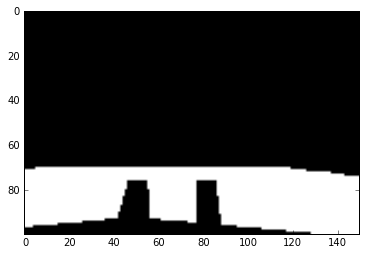

In [14]:
p3dx.tilt(-0.47)
try:
    while True:
        follow_line()
        if isEnd():
            break;
        getObs()
        follow_obs()
        getLine()
except KeyboardInterrupt:
    move(0,0)

---
#### Try-a-Bot: an open source guide for robot programming
Developed by:
[![Robotic Intelligence Lab @ UJI](img/logo/robinlab.png "Robotic Intelligence Lab @ UJI")](http://robinlab.uji.es)

Sponsored by:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="http://www.ieee-ras.org"><img src="img/logo/ras.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.cyberbotics.com"><img src="img/logo/cyberbotics.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="http://www.theconstructsim.com"><img src="img/logo/theconstruct.png"></a>
</td>
</tr>
</table>

Follow us:
<table>
<tr>
<td style="border:1px solid #ffffff ;">
<a href="https://www.facebook.com/RobotProgrammingNetwork"><img src="img/logo/facebook.png"></a>
</td>
<td style="border:1px solid #ffffff ;">
<a href="https://www.youtube.com/user/robotprogrammingnet"><img src="img/logo/youtube.png"></a>
</td>
</tr>
</table>